In [394]:
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")

cosmic_color = "seagreen"
nu_color = "orangered"

MuonFile = "MuonSimOut.txt"

if MuonFile=="MuonSimOut.txt":
    rate = 178282/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
elif MuonFile=="MuonSimOutTight.txt":
    rate = 58842.1/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
elif MuonFile=="MuonSimPrototypeOut.txt":
    rate = 29903.5/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
    
#rate *= 3 # for the number of detectors

n_bunches = 72 * ((3 + 3 + 4)*3 + (3 + 3 + 3))
n_missing_bunches = 3*(8*(2+2+3) + 2*38 + 39) + (8 * (2+2+2) + 38 * 2 + 119) # not correct it seems
cycle_time = 88924 #ns
duty_factor = 25*n_bunches / cycle_time
eff_duty_factor = 2.5/25 * duty_factor # using beam timing cut
rate *= eff_duty_factor

n_months_HLLHC = 58#4*6
n_seconds_HLLHC = n_months_HLLHC * 30.5 * 24 * 60 * 60

cuts = ["No Cuts","Beam Timing", "Panel $\Delta t$", "Aggresive 1D Cut", "Conservative 1D Cut", "2D Cut"]
nu_rate_dict = {cut:0 for cut in cuts}
cosmic_rate_dict = {cut:0 for cut in cuts}

c = 3e-1 # m / ns

# Load the neutrinos

In [395]:
siren_data = pd.concat((pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacing/LHCb_LHC13_EPOSLHC_light_14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacing/LHCb_LHC13_EPOSLHC_light_-14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacing/LHCb_LHC13_BKSS_charm_14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacing/LHCb_LHC13_BKSS_charm_-14.parquet")))

# Load the cosmics

In [396]:
data = pd.read_csv(MuonFile,delim_whitespace=" ")
data.keys()

Index(['hit1', 'hit2', 'hitboth', 't1', 't2', 'int1_x', 'int1_y', 'int1_z',
       'int2_x', 'int2_y', 'int2_z', 'theta', 'phi', 'x0', 'y0', 'z0', 'dx',
       'dy', 'dz'],
      dtype='object')

In [397]:
cosmic_data_hit1 = data.query("hit1==1")
cosmic_data_hit2 = data.query("hit2==1")
singles_rate = (len(cosmic_data_hit1)+len(cosmic_data_hit2))*rate/Ngen
print("Singles rate = ",singles_rate)
cosmic_data = data.query("hitboth==1")
print("Coincidence rate = ",len(cosmic_data)*rate/Ngen)
cosmic_rate_dict["No Cuts"] = len(cosmic_data)*rate/Ngen/eff_duty_factor
cosmic_rate_dict["Beam Timing"] = len(cosmic_data)*rate/Ngen

Singles rate =  128.02968750482435
Coincidence rate =  131.6283354575885


In [398]:
cosmic_data["first_plane"] = np.array(cosmic_data.t1 > cosmic_data.t2,dtype=int) + 1
for coord in ["x","y","z"]:
    cosmic_data["first_plane_%s"%coord] = np.where(cosmic_data.first_plane==1,cosmic_data["int1_%s"%coord],cosmic_data["int2_%s"%coord])
    cosmic_data["second_plane_%s"%coord] = np.where(cosmic_data.first_plane==1,cosmic_data["int2_%s"%coord],cosmic_data["int1_%s"%coord])
cosmic_data["muon_height_difference"] = cosmic_data["second_plane_z"] - cosmic_data["first_plane_z"]
cosmic_data["horizontal_displacement"] = cosmic_data["second_plane_y"] - cosmic_data["first_plane_y"]
cosmic_data["vertical_displacement"] = cosmic_data["second_plane_z"] - cosmic_data["first_plane_z"]

# Now load the neutrinos from SIREN

In [399]:
nu_dict = {"first_plane_x":[],
           "first_plane_y": [],
           "first_plane_z": [],
           "second_plane_x": [],
           "second_plane_y": [],
           "second_plane_z": [],
           "weights":[],
           "beam_timing":[]
           }

# 3x2 setup
panel_width = 24.4
panel_height = 7.77
panel_bottom = 0
# prototype setup
# panel_width = 12.2
# panel_height = 2.59
# panel_bottom = (7.77-2.59)/2


for plane in [1]:
    plane_list = [1,2,3]
    plane_list.remove(plane)
    mask = "panel%d_hit_mask_muon_survival==1"%(plane)
    # for op in plane_list:
    #     mask += " and panel%d_hit_mask_muon_survival==0"%op
    int_locations = np.squeeze(siren_data.query(mask)["panel%d_int_locations"%plane])
    int_distances = np.squeeze(siren_data.query(mask)["panel%d_int_distances"%plane])
    vertices = np.squeeze(siren_data.query(mask)["vertex"])
    wgts = np.squeeze(siren_data.query(mask)["weights"])
    for w,vx,dist,loc in zip(wgts,vertices,int_distances,int_locations):
        # distance checks
        first_plane_y = loc[0][1] - panel_bottom
        second_plane_y = loc[1][1] - panel_bottom
        if first_plane_y > panel_height or first_plane_y < 0 : continue
        if second_plane_y > panel_height or second_plane_y < 0: continue
        if abs(loc[0][0]) > panel_width/2: continue
        if abs(loc[1][0]) > panel_width/2: continue
        if (loc[1][2] - loc[0][2]) <= 2.44 - 1e-6: continue # make sure we enter in front, exit in back
        nu_dict["beam_timing"].append((dist[0] + np.linalg.norm(vx[0]))/c)
        nu_dict["first_plane_x"].append(loc[0][0])
        nu_dict["first_plane_y"].append(first_plane_y)
        nu_dict["first_plane_z"].append(loc[0][2])
        nu_dict["second_plane_x"].append(loc[1][0])
        nu_dict["second_plane_y"].append(second_plane_y)
        nu_dict["second_plane_z"].append(loc[1][2])
        nu_dict["weights"].append(w)
    
             
nu_data = pd.DataFrame(nu_dict)
muon_y_difference = np.array(nu_data["second_plane_y"]) - np.array(nu_data["first_plane_y"])
muon_x_difference = np.array(nu_data["second_plane_x"]) - np.array(nu_data["first_plane_x"])
nu_data["muon_height_difference"] = muon_y_difference
nu_data["horizontal_displacement"] = muon_x_difference
nu_data["vertical_displacement"] = muon_y_difference

nu_rate_dict["No Cuts"] = sum(nu_data.weights)/n_seconds_HLLHC


# Timing Cuts

## Time delay w.r.t. beam trigger

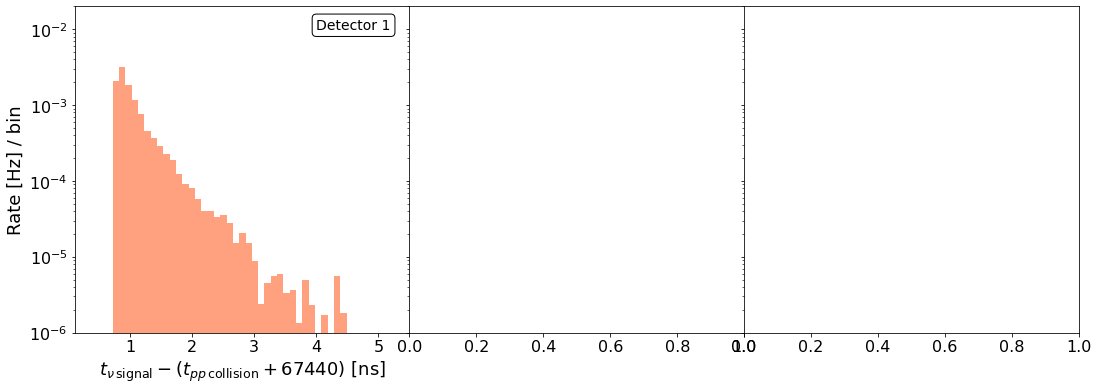

In [431]:
bin_centers = [67440,
               #70773,
               #74107
              ]
bw = 5

fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True)
fig.subplots_adjust(wspace=0)
for ib,bc in enumerate(bin_centers):
    d,b,_ = ax[ib].hist(nu_data["beam_timing"]-bc,weights=nu_data["weights"]/n_seconds_HLLHC,
                bins=np.linspace(0,bw,50),#np.linspace(bc-bw/2,bc+bw/2,100),
                alpha=0.5,color=nu_color,label="Neutrino Signal")
    beam_timing_loss = sum(d[b[:-1]<=3])/sum(d)
    ax[ib].set_xlabel(r"$t_{\nu\,{\rm signal}} - (t_{pp\,{\rm collision}} + %d)$ [ns]"%bc)
    ax[ib].text(bw-1,0.01,"Detector %d"%(ib+1),fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
    ax[ib].semilogy()
    ax[ib].set_xlim(0.1,bw+0.5)
    ax[ib].set_xticks(range(1,bw+1))
ax[0].set_ylabel("Rate [Hz] / bin")
ax[0].set_ylim(1e-6,2e-2)
plt.savefig("Figures/BeamTiming.pdf",dpi=100)
plt.show()
nu_rate_dict["Beam Timing"] = beam_timing_loss * nu_rate_dict["No Cuts"]

## Time delay between scintillator hits

In [432]:
cosmic_data["delta_t"] = np.sqrt((cosmic_data.int2_x - cosmic_data.int1_x)**2 + 
                                 (cosmic_data.int2_y - cosmic_data.int1_y)**2 + 
                                 (cosmic_data.int2_z - cosmic_data.int1_z)**2) /c
nu_data["delta_t"] = np.sqrt((nu_data.second_plane_x - nu_data.first_plane_x)**2 + 
                             (nu_data.second_plane_y - nu_data.first_plane_y)**2 + 
                             (nu_data.second_plane_z - nu_data.first_plane_z)**2) /c

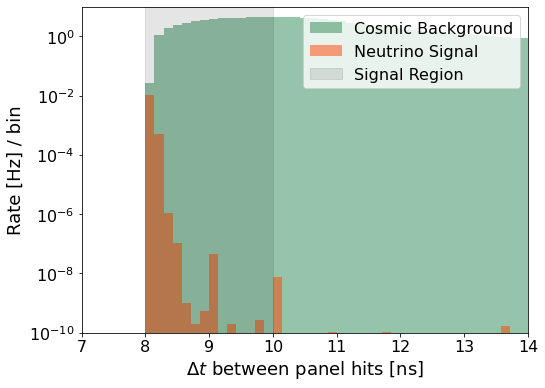

True coincidence rate w/ time cut =  44.94868783989924
Accidnetal coincidence rate w/ time cut =  0.00041481618751563093


In [433]:
plt.hist(cosmic_data["delta_t"],bins=np.linspace(7,14,50),weights=rate/Ngen*np.ones_like(cosmic_data["delta_t"]),
         alpha=0.5,color=cosmic_color,label="Cosmic Background")
plt.hist(nu_data["delta_t"],bins=np.linspace(7,14,50),weights=nu_data["weights"]/n_seconds_HLLHC,
         alpha=0.5,color=nu_color,label="Neutrino Signal")
plt.fill_between([8,10],[10,10],color="black",alpha=0.1,label="Signal Region")
plt.semilogy()
plt.ylim(1e-10,10)
plt.xlim(7,14)
plt.xlabel(r"$\Delta t$ between panel hits [ns]")
plt.ylabel("Rate [Hz] / bin")
plt.legend(loc="upper right")
plt.savefig("Figures/Panel_DeltaT.pdf",dpi=100)
plt.show()

cosmic_data_time_cut = cosmic_data.query("delta_t > 8 and delta_t < 10")
nu_data_time_cut = nu_data.query("delta_t > 8 and delta_t < 10")
print("True coincidence rate w/ time cut = ",len(cosmic_data_time_cut)*rate/Ngen)
print("Accidnetal coincidence rate w/ time cut = ",singles_rate* 1.62e3 * 2e-9)
nu_rate_dict["Panel $\\Delta t$"] = beam_timing_loss*sum(nu_data_time_cut["weights"])/n_seconds_HLLHC
cosmic_rate_dict["Panel $\\Delta t$"] = len(cosmic_data_time_cut)*rate/Ngen


# Spatial Cuts

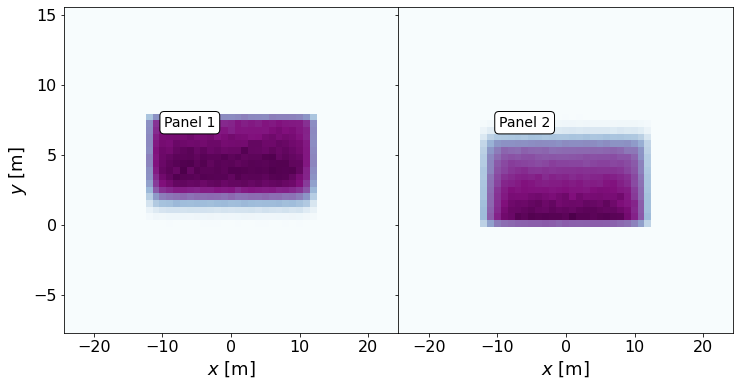

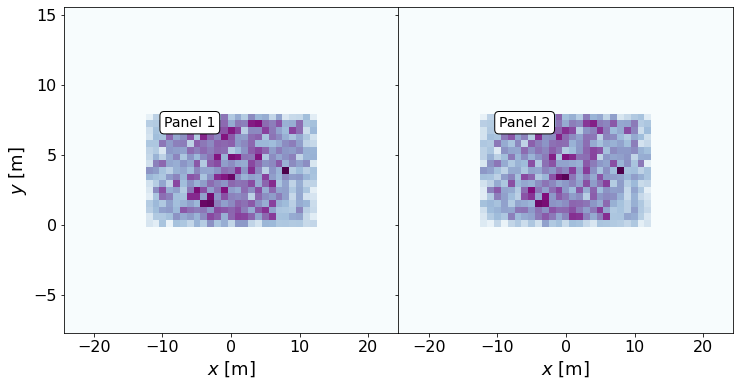

In [434]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)

ybins = np.linspace(-2*panel_width/2,2*panel_width/2,50)
zbins = np.linspace(-panel_height,2*panel_height,50)

ax[0].hist2d(cosmic_data["first_plane_y"],cosmic_data["first_plane_z"],bins=(ybins,zbins))
ax[1].hist2d(cosmic_data["second_plane_y"],cosmic_data["second_plane_z"],bins=(ybins,zbins))
ax[0].set_xlabel(r"$x$ [m]")
ax[0].set_ylabel(r"$y$ [m]")
ax[1].set_xlabel(r"$x$ [m]")
ax[0].text(-0.4*panel_width,0.9*panel_height,"Panel 1",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-0.4*panel_width,0.9*panel_height,"Panel 2",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
plt.savefig("Figures/Panel1Panel2_cosmics.pdf",dpi=100)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)
xbins = ybins
ybins = zbins


ax[0].hist2d(nu_data["first_plane_x"],nu_data["first_plane_y"],bins=(xbins,ybins),weights=nu_data["weights"])
ax[1].hist2d(nu_data["second_plane_x"],nu_data["second_plane_y"],bins=(xbins,ybins),weights=nu_data["weights"])
ax[0].set_xlabel(r"$x$ [m]")
ax[0].set_ylabel(r"$y$ [m]")
ax[1].set_xlabel(r"$x$ [m]")
ax[0].text(-0.4*panel_width,0.9*panel_height,"Panel 1",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-0.4*panel_width,0.9*panel_height,"Panel 2",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
plt.savefig("Figures/Panel1Panel2_neutrinos.pdf",dpi=100)
plt.show()

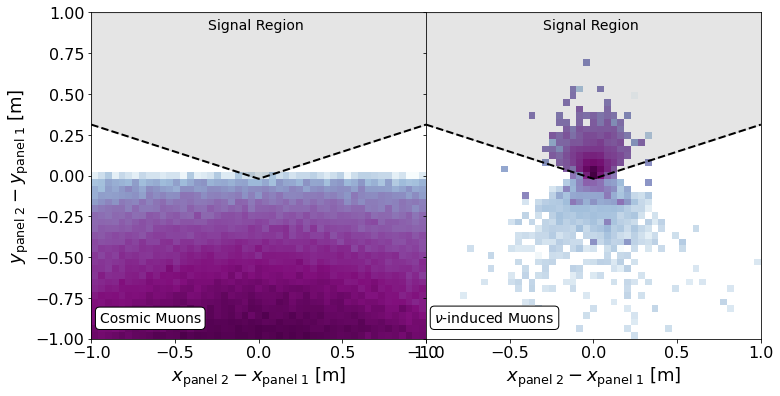

In [435]:
vertical_cut = -0.02
horizontal_cut = 0.05
opening_angle = 2.5
cut = "2Dtr"

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)

cos_map = ax[0].hist2d(cosmic_data["horizontal_displacement"],cosmic_data["vertical_displacement"],
                       bins=np.linspace(-1,1,50),weights=rate/Ngen*n_seconds_HLLHC*np.ones(len(cosmic_data)),
                       norm=LogNorm())
nu_map = ax[1].hist2d(nu_data["horizontal_displacement"],nu_data["vertical_displacement"],
                      bins=np.linspace(-1,1,50),weights=nu_dict["weights"],
                      norm=LogNorm())

if cut=="1D":
    xs = [-1,1]
    ys = [vertical_cut,vertical_cut]
    
elif cut=="2Dsq":
    xs = [-horizontal_cut,-horizontal_cut,horizontal_cut,horizontal_cut]
    ys = [1,vertical_cut,vertical_cut,1]
if cut=="2Dtr":
    xs = [-1,0,1]
    ys = [1./np.tan(opening_angle/2) + vertical_cut, vertical_cut, 1./np.tan(opening_angle/2) + vertical_cut]
    for i in range(2): ax[i].text(-0.3,0.9,"Signal Region",color="black",alpha=1,fontsize=14)
else:
    xs=[]
    yx=[]
if xs and ys: 
    for i in range(2): 
        ax[i].plot(xs,ys,color="black",ls="--")
        ax[i].fill_between(xs,ys,np.ones_like(ys),color="black",alpha=0.1)
    
ax[0].text(-0.95,-0.9,"Cosmic Muons",fontsize=14,bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-0.95,-0.9,r"$\nu$-induced Muons",fontsize=14,bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
for i in range(2): 
    ax[i].set_xlabel(r"$x_{\rm panel\;2} - x_{\rm panel\;1}$ [m]")
ax[0].set_ylabel(r"$y_{\rm panel\;2} - y_{\rm panel\;1}$ [m]")
plt.savefig("Figures/PanelDeltaSpatial.pdf",dpi=100)
plt.show()

# Vertical Cut

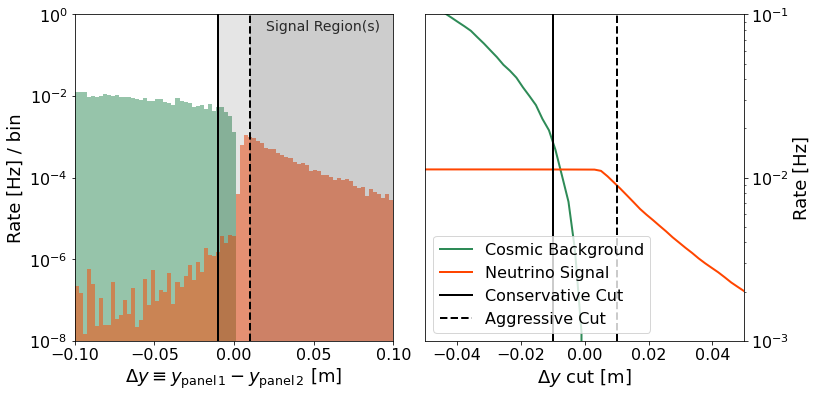

In [436]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.subplots_adjust(wspace=0.1)

hist_bins = np.linspace(-0.1,0.1,80)

ax[0].hist(cosmic_data_time_cut["muon_height_difference"],bins=hist_bins,weights=rate/Ngen*np.ones_like(cosmic_data_time_cut["muon_height_difference"]),
           alpha=0.5,label="Cosmic Background",color=cosmic_color)
ax[0].hist(nu_data_time_cut["muon_height_difference"],bins=hist_bins,weights=nu_data_time_cut["weights"]/n_seconds_HLLHC,
           alpha=0.5,label="Neutrino Signal",color=nu_color)
vertical_resolution_array = np.linspace(-0.05,0.05,50)
bkg_rate = np.empty_like(vertical_resolution_array)
sig_rate = np.empty_like(vertical_resolution_array)
for i,vc in enumerate(vertical_resolution_array):
    num_bkg = sum(cosmic_data_time_cut["muon_height_difference"] >= vc)
    num_sig = sum(nu_data_time_cut.query("muon_height_difference > @vc")["weights"])
    bkg_rate[i] = rate*num_bkg/Ngen
    sig_rate[i] = num_sig / n_seconds_HLLHC
ax[1].plot(vertical_resolution_array,bkg_rate,label="Cosmic Background",color=cosmic_color)
ax[1].plot(vertical_resolution_array,sig_rate,label="Neutrino Signal",color=nu_color)
ax[0].fill_between([-0.01,0.5],[1,1],color="black",alpha=0.1)
ax[0].fill_between([0.01,0.5],[1,1],color="black",alpha=0.1)
ax[0].plot([-0.01,-0.01],[1e-8,1],color="black")
ax[0].plot([0.01,0.01],[1e-8,1],color="black",ls="--")
ax[0].text(0.02,0.4,"Signal Region(s)",color="black",alpha=0.8,fontsize=14)
ax[0].set_xlim(hist_bins[0],hist_bins[-1])
ax[0].set_ylim(1e-8,1)
ax[1].plot([-0.01,-0.01],[1e-3,1e-1],color="black",label=r"Conservative Cut")
ax[1].plot([0.01,0.01],[1e-3,1e-1],color="black",ls="--",label=r"Aggressive Cut")
ax[1].set_xlim(vertical_resolution_array[0],vertical_resolution_array[-1])
ax[1].set_ylim(1e-3,1e-1)
ax[0].semilogy()
ax[1].legend()
ax[1].semilogy()
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].set_xlabel(r"$\Delta y \equiv y_{\rm panel\,1} - y_{\rm panel\,2}$ [m]")
ax[0].set_ylabel(r"Rate [Hz] / bin")
ax[1].set_xlabel(r"$\Delta y$ cut [m]")
ax[1].set_ylabel(r"Rate [Hz]")
plt.savefig("Figures/VerticalCut.pdf",dpi=100)
plt.show()

for vc,key in zip([-0.01,0.01],
                            ["Conservative 1D Cut","Aggresive 1D Cut"]):
    num_bkg = sum(cosmic_data_time_cut["muon_height_difference"] >= vc)
    num_sig = sum(nu_data_time_cut.query("muon_height_difference > @vc")["weights"])
    bkg_rate = rate*num_bkg/Ngen
    sig_rate = num_sig / n_seconds_HLLHC
    nu_rate_dict[key] = sig_rate*beam_timing_loss
    cosmic_rate_dict[key] = bkg_rate

# 2D Cut

In [422]:
N = 75
vertical_cut_array = np.linspace(-0.1,0.02,N)
opening_angle_cut_array = np.linspace(0.01,np.pi,N)
#horizontal_cut_array = np.linspace(0.01,0.5,N)

sig_rate2D = np.zeros((N,N))
bkg_rate2D = np.zeros((N,N))
for iv,vc in enumerate(vertical_cut_array):
    print(iv)
    for ih,oac in enumerate(opening_angle_cut_array):
        slope = 1./ np.arctan(oac/2)
        cut = "vertical_displacement > @slope * abs(horizontal_displacement) + @vc"
        #cut = "vertical_displacement > @vc and horizontal_displacement > -@hc and horizontal_displacement < @hc"
        num_bkg = len(cosmic_data_time_cut.query(cut))
        num_sig = sum(nu_data_time_cut.query(cut)["weights"])
        sig_rate2D[iv,ih] = (num_sig/n_seconds_HLLHC)
        bkg_rate2D[iv,ih] = (rate*num_bkg/Ngen)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


4
0.010861075628328658 0.0002814852323332284


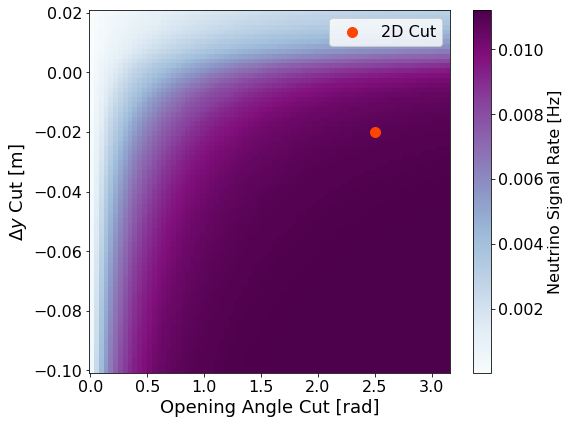

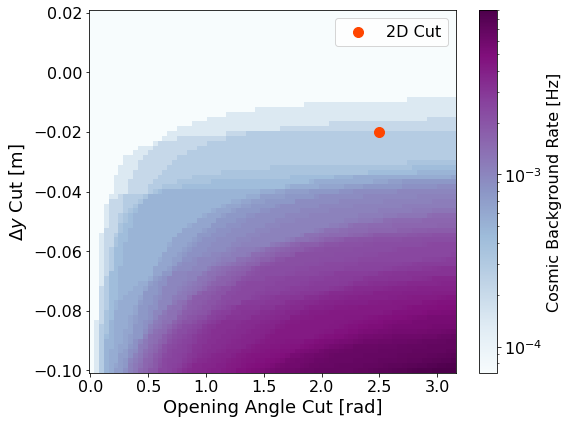

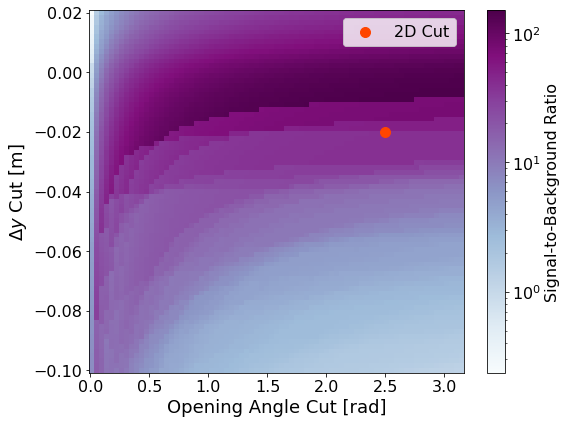

In [437]:
slope = 1./ np.arctan(opening_angle/2)
cut = "vertical_displacement > @slope * abs(horizontal_displacement) + @vertical_cut"
num_bkg = len(cosmic_data_time_cut.query(cut))
num_sig = sum(nu_data_time_cut.query(cut)["weights"])
sig_rate_2Dcut = (num_sig/n_seconds_HLLHC)
bkg_rate_2Dcut = (rate*num_bkg/Ngen)
nu_rate_dict["2D Cut"] = sig_rate_2Dcut*beam_timing_loss
cosmic_rate_dict["2D Cut"] = bkg_rate_2Dcut
print(num_bkg)
print(sig_rate_2Dcut,bkg_rate_2Dcut)

plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,sig_rate2D)
cbar = plt.colorbar()
cbar.set_label("Neutrino Signal Rate [Hz]",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([opening_angle],[vertical_cut],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_Signal.pdf",dpi=100)
plt.show()

bkg_rate_filled = np.where(bkg_rate2D>0,bkg_rate2D,np.min(bkg_rate2D[bkg_rate2D>0]))

plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,bkg_rate_filled,norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label("Cosmic Background Rate [Hz]",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([opening_angle],[vertical_cut],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_Background.pdf",dpi=100)
plt.show()

sig_bkg_ratio = sig_rate2D/bkg_rate_filled#np.where(bkg_rate>0,sig_rate/bkg_rate,sig_rate/(rate/Ngen))
# plt.contour(opening_angle_cut_array,vertical_cut_array,sig_bkg_ratio,
#             levels=[1,10],colors="white",linestyles=["-","--"],linewidths=3)
plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,
               sig_bkg_ratio,norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label("Signal-to-Background Ratio",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([opening_angle],[vertical_cut],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_SignalBackgroundRatio.pdf",dpi=100)
plt.show()



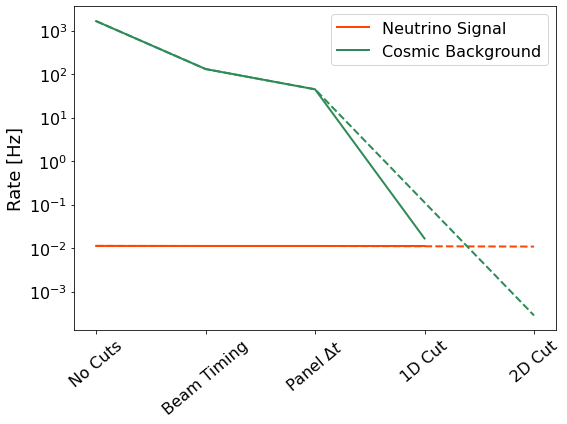

In [482]:
# background summary
#print(nu_rate_dict)
a_track_keys = ["No Cuts","Beam Timing", "Panel $\Delta t$", "Aggresive 1D Cut"]
b_track_keys = ["No Cuts","Beam Timing", "Panel $\Delta t$", "Conservative 1D Cut"]
c_track_keys = ["No Cuts","Beam Timing", "Panel $\Delta t$", "2D Cut"]
for keys in [b_track_keys,c_track_keys]:
    if "2D Cut" in keys:
        ls = "--"
        label = None
    else:
        ls = "-"
    ls = "--" if "2D Cut" in keys else "-"
    nu_rate = [nu_rate_dict[k] for k in keys]
    cosmic_rate = [cosmic_rate_dict[k] for k in keys]
    #keys[keys=="Conservative 1D Cut"] = "1D Cut"
    keys = np.where(np.array(keys)=="Conservative 1D Cut","1D Cut",keys)
    #print(np.where(np.array(keys)=="Conservative 1D Cut"))
    plt.plot(keys,nu_rate,color=nu_color,ls=ls,label="Neutrino Signal" if "2D Cut" not in keys else None)
    plt.plot(keys,cosmic_rate,color=cosmic_color,ls=ls,label="Cosmic Background" if "2D Cut" not in keys else None)
plt.semilogy()
plt.legend()
plt.xticks(rotation=40)
plt.gca().set_yticks(np.logspace(-3,3,7),minor=True)
plt.ylabel("Rate [Hz]")
plt.tight_layout()
plt.savefig("Figures/BackgroundOverview.pdf",dpi=100)
plt.show()

# Prototype detector sensitivity

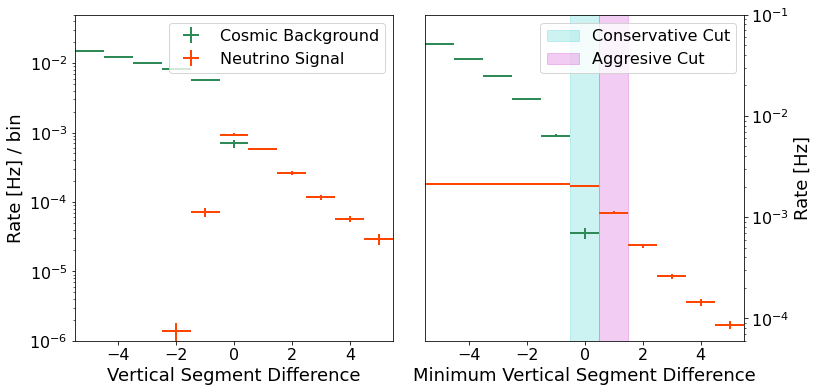

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.subplots_adjust(wspace=0.1)

segment_width = 0.02 #m
n_spatial_bins = int(panel_height/segment_width)
first_plane_spatial_bins = np.linspace(0,panel_height,n_spatial_bins)
second_plane_spatial_bins = np.linspace(segment_width/2,panel_height+segment_width/2,n_spatial_bins)
nu_data_time_cut["first_plane_segment_ID"] = np.digitize(nu_data_time_cut["first_plane_y"],first_plane_spatial_bins)
nu_data_time_cut["second_plane_segment_ID"] = np.digitize(nu_data_time_cut["second_plane_y"],second_plane_spatial_bins)
nu_data_time_cut["vertical_segment_diff"] = nu_data_time_cut["second_plane_segment_ID"] - nu_data_time_cut["first_plane_segment_ID"]
cosmic_data_time_cut["first_plane_segment_ID"] = np.digitize(cosmic_data_time_cut["first_plane_z"],first_plane_spatial_bins)
cosmic_data_time_cut["second_plane_segment_ID"] = np.digitize(cosmic_data_time_cut["second_plane_z"],second_plane_spatial_bins)
cosmic_data_time_cut["vertical_segment_diff"] = cosmic_data_time_cut["second_plane_segment_ID"] - cosmic_data_time_cut["first_plane_segment_ID"]

vertical_segment_bins = np.arange(-5,6)
nu_rate_vs_vertical_segment = np.zeros_like(vertical_segment_bins,dtype=float)
nu_err_vs_vertical_segment = np.zeros_like(vertical_segment_bins,dtype=float)
cosmic_rate_vs_vertical_segment = np.zeros_like(vertical_segment_bins,dtype=float)
cosmic_err_vs_vertical_segment = np.zeros_like(vertical_segment_bins,dtype=float)
for ivsb,vsb in enumerate(vertical_segment_bins):
    nu_rate_vs_vertical_segment[ivsb] = sum(nu_data_time_cut.query("vertical_segment_diff==@vsb")["weights"]) / n_seconds_HLLHC
    nu_err_vs_vertical_segment[ivsb] = np.sqrt(sum(nu_data_time_cut.query("vertical_segment_diff==@vsb")["weights"]**2)) / n_seconds_HLLHC
    cosmic_rate_vs_vertical_segment[ivsb] = len(cosmic_data_time_cut.query("vertical_segment_diff==@vsb")) * rate/Ngen
    cosmic_err_vs_vertical_segment[ivsb] = np.sqrt(len(cosmic_data_time_cut.query("vertical_segment_diff==@vsb")))  * rate/Ngen
ax[0].errorbar(vertical_segment_bins,cosmic_rate_vs_vertical_segment,
               xerr=0.5,yerr=cosmic_err_vs_vertical_segment,
               linestyle="none",color=cosmic_color,label="Cosmic Background")
ax[0].errorbar(vertical_segment_bins,nu_rate_vs_vertical_segment,
               xerr=0.5,yerr=nu_err_vs_vertical_segment,
               linestyle="none",color=nu_color,label="Neutrino Signal")


nu_rate_vs_vertical_segment_cut = np.zeros_like(vertical_segment_bins,dtype=float)
nu_err_vs_vertical_segment_cut = np.zeros_like(vertical_segment_bins,dtype=float)
cosmic_rate_vs_vertical_segment_cut = np.zeros_like(vertical_segment_bins,dtype=float)
cosmic_err_vs_vertical_segment_cut = np.zeros_like(vertical_segment_bins,dtype=float)
for ivsb,vsb in enumerate(vertical_segment_bins):
    nu_rate_vs_vertical_segment_cut[ivsb] = sum(nu_data_time_cut.query("vertical_segment_diff>=@vsb")["weights"]) / n_seconds_HLLHC
    nu_err_vs_vertical_segment_cut[ivsb] = np.sqrt(sum(nu_data_time_cut.query("vertical_segment_diff>=@vsb")["weights"]**2)) / n_seconds_HLLHC
    cosmic_rate_vs_vertical_segment_cut[ivsb] = len(cosmic_data_time_cut.query("vertical_segment_diff>=@vsb")) * rate/Ngen
    cosmic_err_vs_vertical_segment_cut[ivsb] = np.sqrt(len(cosmic_data_time_cut.query("vertical_segment_diff>=@vsb")))  * rate/Ngen
ax[1].errorbar(vertical_segment_bins,nu_rate_vs_vertical_segment_cut,
               xerr=0.5,yerr=nu_err_vs_vertical_segment_cut,
               linestyle="none",color=nu_color)

ax[1].errorbar(vertical_segment_bins,cosmic_rate_vs_vertical_segment_cut,
               xerr=0.5,yerr=cosmic_err_vs_vertical_segment_cut,
               linestyle="none",color=cosmic_color)

ax[1].fill_between([-0.5,0.5],[1e-1,1e-1],color="c",alpha=0.2,label=r"Conservative Cut")
ax[1].fill_between([0.5,1.5],[1e-1,1e-1],color="m",alpha=0.2,label=r"Aggresive Cut")
    

ax[0].semilogy()
ax[0].legend()
ax[0].set_xlim(vertical_segment_bins[0]-0.5,vertical_segment_bins[-1]+0.5)
ax[0].set_ylim(1e-6,5e-2)
ax[0].set_xlabel("Vertical Segment Difference")
ax[0].set_ylabel("Rate [Hz] / bin")

ax[1].semilogy()
ax[1].legend()
ax[1].set_xlim(vertical_segment_bins[0]-0.5,vertical_segment_bins[-1]+0.5)
ax[1].set_ylim(6e-5,1e-1)
ax[1].set_xlabel("Minimum Vertical Segment Difference")
ax[1].set_ylabel("Rate [Hz]")
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
plt.savefig("Figures/Prototype1DSegmentCut.pdf",dpi=100)
plt.show()

In [322]:
Ndays = 30.5*6
days_range = np.logspace(-2,np.log10(Ndays),100)
seconds_range = 60*60*24*days_range
run3_LHCb_scale = 2./3000.
run3_CMS_scale = 70./3000.
nu_rate_conservative = nu_rate_vs_vertical_segment_cut[vertical_segment_bins==0].item()
nu_rate_aggresive = nu_rate_vs_vertical_segment_cut[vertical_segment_bins==1].item()
cosmic_rate_conservative = cosmic_rate_vs_vertical_segment_cut[vertical_segment_bins==0].item()
cosmic_rate_aggresive = cosmic_rate_vs_vertical_segment_cut[vertical_segment_bins==1].item()

### Likelihood construction

We compare Poisson for PDFs $P(k|s+b)$ and $P(k|b)$

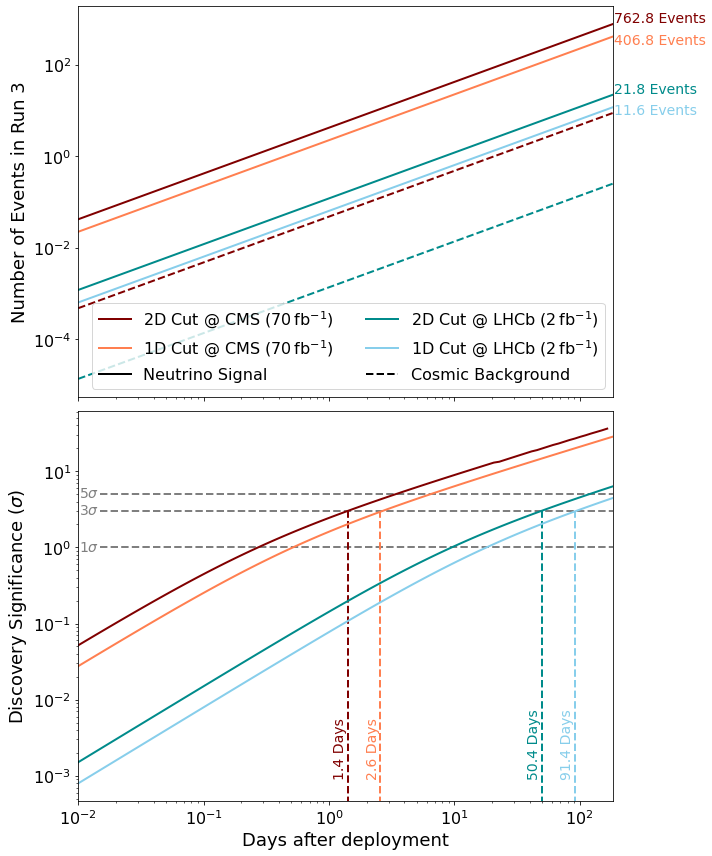

In [375]:
from scipy.stats import poisson,norm
fig,ax = plt.subplots(2,1,figsize=(10,12),sharex=True)
fig.subplots_adjust(hspace=0)
for sig in [1,3,5]:
    ax[1].text(1.02*days_range[0],0.9*sig,r"$%d\sigma$"%sig,color="black",fontsize=14,alpha=0.5)
    ax[1].plot([days_range[4],days_range[-1]],[sig,sig],color="black",ls="--",alpha=0.5)

colors = ["maroon","coral","darkcyan","skyblue"]
ic = 0
for scale,label_suffix in zip([run3_CMS_scale,run3_LHCb_scale],
                       [r"CMS ($70\,{\rm fb}^{-1}$)",r"LHCb ($2\,{\rm fb}^{-1}$)"]):
    sig_events_1Daggresive = scale*nu_rate_aggresive*seconds_range
    sig_events_1Dconservative = scale*nu_rate_conservative*seconds_range
    sig_events_2D = scale*sig_rate_2Dcut*seconds_range
    bkg_events_1Daggresive = scale*cosmic_rate_aggresive*seconds_range
    bkg_events_1Dconservative = scale*cosmic_rate_conservative*seconds_range
    bkg_events_2D = scale*bkg_rate_2Dcut*seconds_range
    for sig_events,bkg_events,label_prefix in zip([sig_events_2D,sig_events_1Daggresive],
                                                  [bkg_events_2D,bkg_events_1Daggresive],
                                                  ["2D Cut","1D Cut"]):
        color = colors[ic]
        ic+=1
        label = label_prefix + " @ " + label_suffix
        if np.all(bkg_events<=0):
            pval = poisson.pmf(0,sig_events)
            ax[0].plot(days_range,sig_events,ls=ls,color=color,label=label)
        else:
            ax[0].plot(days_range,sig_events,ls=ls,color=color,label=label)
            ax[0].plot(days_range,bkg_events,color=color,ls="--")
            pval = poisson.cdf(bkg_events,sig_events+bkg_events)
        significance = norm.isf(pval/2)
        ax[1].plot(days_range,significance,ls=ls,color=color,label=label)
        evidence_date_idx = np.argmin(np.abs(significance-3))
        evidence_date = days_range[evidence_date_idx]
        ax[1].plot([evidence_date,evidence_date],[0,significance[evidence_date_idx]],color=color,ls="--")
        ax[1].text(0.76*evidence_date,1e-3,"%2.1f Days"%evidence_date,color=color,
                   fontsize=14,rotation=90)
        factor = 1.1 if "2D" in label_prefix else 0.7
        ax[0].text(1.02*days_range[-1],factor*sig_events[-1],"%2.1f Events"%sig_events[-1],color=color,fontsize=14)
    
ax[0].plot([],[],color="black",label="Neutrino Signal")
ax[0].plot([],[],color="black",ls="--",label="Cosmic Background")

ax[0].loglog()
ax[1].loglog()
ax[1].set_xlabel("Days after deployment")
ax[0].set_ylabel("Number of Events in Run 3")
ax[1].set_ylabel(r"Discovery Significance ($\sigma$)")
handles, labels = ax[0].get_legend_handles_labels()
order = [0,1,4,2,3,5]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
             ncol=2)
#ax[1].legend()
ax[0].set_xlim(days_range[0],days_range[-1])
plt.tight_layout()
plt.savefig("Figures/PrototypeSensitivity.pdf",dpi=100)
plt.show()